In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats

import matplotlib.pyplot as plt
import cv2
import matplotlib.gridspec as gridspec
import matplotlib.font_manager as fm

from helper import *

# Goal-directed Behaviors

## 1. Manual Analysis

We measured three behaviors ("Approach hands to food (n)," "Bring the food to the mouth (n)," and "Drop the food (n)") and "Food intake (g)" in the manual analysis. One can use the samples in `Examples/Palatable_DLC_MonkeyX_Y.csv (X = A / B / C, Y = CNO / Vehicle)` and `Examples/Palatable_DLC_params.csv` to reproduce the same results as below. Here, we show the analysis for the first behavior (AH):

In [2]:
cases = [(i, j) for i in ['A', 'B', 'C'] for j in ['CNO', 'Vehicle']]
filenames = ['Examples/Palatable_DLC_Monkey{}_{}.csv'.format(i, j) for (i, j) in cases]

crit = 0.25
filter = 360
latency = 36
dur = 36

log = pd.read_csv('Examples/Palatable_Log_Example1.csv', index_col=0)

num_in = []
num_out = []
lowspeed_len = []
bhvs_len = []

bhv = 'Approach hands to food (from tray)'

for (case, filepath) in zip(cases, filenames):
    df = pd.read_csv(filepath, index_col=0, header=[1, 2], skiprows=0)
    manual = (log.loc[(log[['Cycle', 'Subject', 'CNO / Vehicle', 'Behavior']] == ('3cycle', *case, bhv)).all(axis=1), 'Time_Relative_sf'].values * 24.0).astype(int)

    in_count, out_count = get_foc_behaviors_count(df, manual, crit, filter, latency, dur)
    num_in.append(in_count)

num_in = np.array(num_in)

pd.DataFrame(index=pd.MultiIndex.from_tuples(cases), columns=['AH'], data=num_in.reshape(-1, 1))

AH
A CNO      19
  Vehicle   4
B CNO      31
  Vehicle   8
C CNO      38
  Vehicle   7

We compared (1) CNO-injected and control subjects for each index by the paired t-test and (2) divided the values of CNO-injected subjects by the corresponding values of control subjects, and compared the rates of changes with 0, so that we can observe the rate of change caused by CNO injection.

In [3]:
data = num_in.reshape(-1, 2)

print('p-value (abs. value) : {:.3f}'.format(scipy.stats.ttest_rel(data[:, 0], data[:, 1]).pvalue))
print('p-value (rate of change) : {:.3f}'.format(scipy.stats.ttest_1samp(data[:, 0] / data[:, 1] - 1 , popmean=0).pvalue))

p-value (abs. value) : 0.038
p-value (rate of change) : 0.015


Now the example figure for the first index looks like:

c:\Users\bih\Desktop\bihfiles\chemo\Monkey_chemogenetics\helper.py:603: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


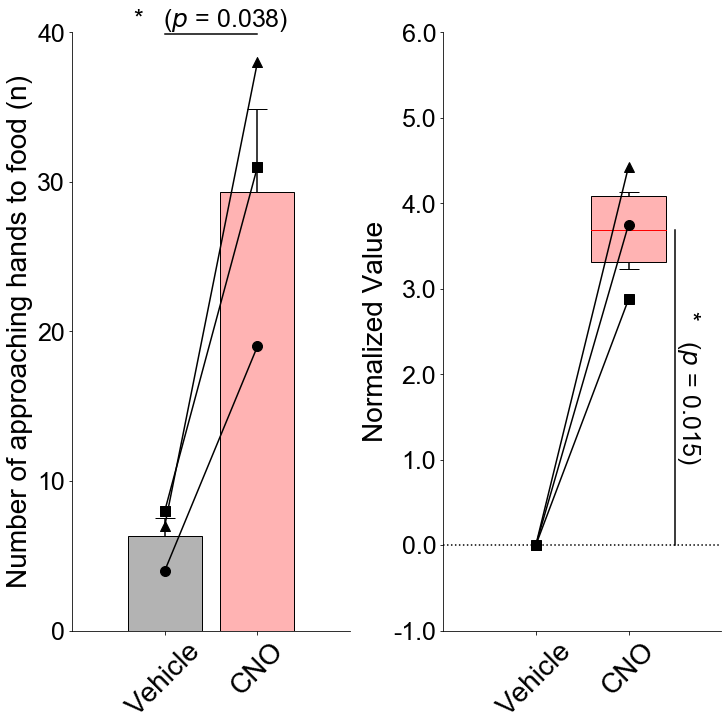

In [4]:
path = 'Figures/Fig 4E.png'
draw_picture(data.T[::-1], '', 'Number of approaching hands to food (n)', path)

## 2. Deep Learning-based analysis

We measured three behaviors ("Tray Approach (n)," and "Bout (n)" and ""Duration in Food Zone (s)") in the deep learning-based analysis. One can use the samples in `Examples/Palatable_DLC_MonkeyX_Y.csv (X = A / B / C, Y = CNO / Vehicle)` to reproduce the same results as below (those are raw outputs from DeepLabCut). We computed some parameters for each video, such as `Examples/Palatable_DLC_params.csv`.

* `fz x` is the x-coordinate of the food zone.
* `trayx` and `trayy` are the x- and y-coordinate of the tray, respectively.
* `tray-hand dist` is the threshold distance between the tray and hand, which is a criterion for "Tray Approach."
* `tray-mouth dist` is the threshold distance between the tray and mouth, which is a criterion for "Bout."

In [5]:
params_df = pd.read_csv('Examples/Palatable_DLC_params.csv', index_col=[0, 1], header=0)
params_df

fz x  trayx  trayy  tray-hand dist  tray-mouth dist
A CNO       847   1137    459       97.693398        22.203603
  Vehicle   843   1142    455      106.404887        20.248457
B CNO       809   1133    450      120.904921        21.189620
  Vehicle   866   1147    454       94.540996        21.587033
C CNO       906   1168    457       94.366308        22.472205
  Vehicle   845   1139    455       89.157165        17.492856

Based on those parameters, we computed each index for each video. Refer to `helper.py` for the detailed description of each function.

In [6]:
cases = [(i, j) for i in ['A', 'B', 'C'] for j in ['CNO', 'Vehicle']]
filenames = ['Examples/Palatable_DLC_Monkey{}_{}.csv'.format(i, j) for (i, j) in cases]

values = np.array([])

for case, filepath in zip(cases, filenames):
    # Approach
    params = tuple(params_df.loc[case, ['trayx', 'trayy', 'tray-hand dist']])
    coords, _, _ = return_approach(filepath, params, ll_crit=0.9, absolute=True, interval=0.2, FPS=24.0)
    appr = coords['Approach'].sum()

    # Bout
    params = tuple(params_df.loc[case, ['trayx', 'trayy', 'tray-mouth dist', 'tray-hand dist']])
    coords, _, _ = return_bout1(filepath, params, latency1=3.0, latency2=1.0, ll_crit=0.9, interval=0.2, FPS=24.0)
    bout = coords['Bout'].sum()

    # In Food Zone
    fz_x = params_df.loc[case, 'fz x']
    coords, _, _ = return_infz(filepath, fz_x, ll_crit=0.9, absolute=True)
    infz = coords['In'].sum() / 24


    values = np.concatenate((values, np.array([appr, bout, infz])))

values = values.reshape(3, 2, 3)

print(values)

[[[ 55.          31.         866.83333333]
  [ 50.          20.         217.58333333]]

 [[121.          74.         828.54166667]
  [ 80.          44.         204.        ]]

 [[268.         112.         520.45833333]
  [ 66.          18.         309.375     ]]]


Then we compared (1) CNO-injected and control subjects by paired t-test and (2) the rates of changes with 0 by one-sample t-test, as above.

In [7]:
indices = ["Tray Approach (n)", "Bout (n)", "Duration in Food Zone (s)"]

table_values = []

for i, idx in enumerate(indices):
    data = values[:, :, i]
    table_values.append([scipy.stats.ttest_rel(data[:, 0], data[:, 1]).pvalue, scipy.stats.ttest_1samp(data[:, 0] / data[:, 1] - 1, popmean=0).pvalue])

pd.DataFrame(data=table_values, index=indices, columns=['p-value (abs. value)','p-value (rate of change)'])

,p-value (abs. value),p-value (rate of change)
Tray Approach (n),0.305543,0.316977
Bout (n),0.214944,0.296296
Duration in Food Zone (s),0.073472,0.102782


Now the example figure for the first index looks like:

c:\Users\bih\Desktop\bihfiles\chemo\Monkey_chemogenetics\helper.py:603: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


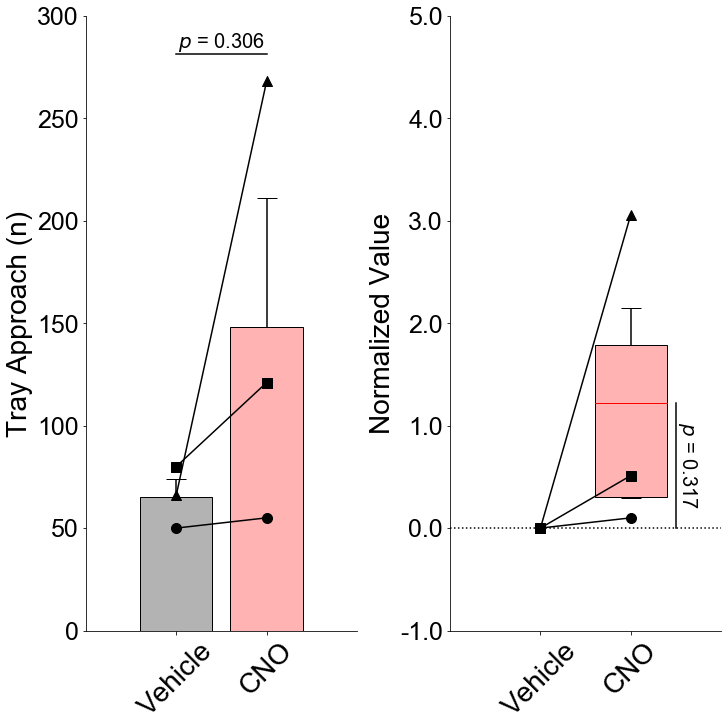

In [8]:
data = values[:, :, 0].T[::-1, :]
path = 'Figures/Fig S2A.png'
draw_picture(data, '', indices[0], path)

##  3. Total Duration of Low Locomotion

In [9]:
crit = 0.25
filter = 360
latency = 36
dur = 36

lowspeed_len = []

for (case, filepath) in zip(cases, filenames):
    df = pd.read_csv(filepath, index_col=0, header=[1, 2], skiprows=0)
    lowspeed_sessions = get_lowspeed(df, crit, filter, latency, dur)
    lowspeed_len.append((lowspeed_sessions[:, 1] - lowspeed_sessions[:, 0]).sum())

lowspeed_len = np.array(lowspeed_len)
data = lowspeed_len.reshape(-1, 2).T[::-1, :] / 24

p1 = scipy.stats.ttest_rel(data[0], data[1]).pvalue
p2 = scipy.stats.ttest_1samp(data[1] / data[0]-1, popmean=0).pvalue

pd.DataFrame(index=['Total Duration of Low Locomotion (s)'], data=[[p1, p2]], columns=['p-value (abs. value)', 'p-value (rate of change)'])


,p-value (abs. value),p-value (rate of change)
Total Duration of Low Locomotion (s),0.078078,0.023594


c:\Users\bih\Desktop\bihfiles\chemo\Monkey_chemogenetics\helper.py:603: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


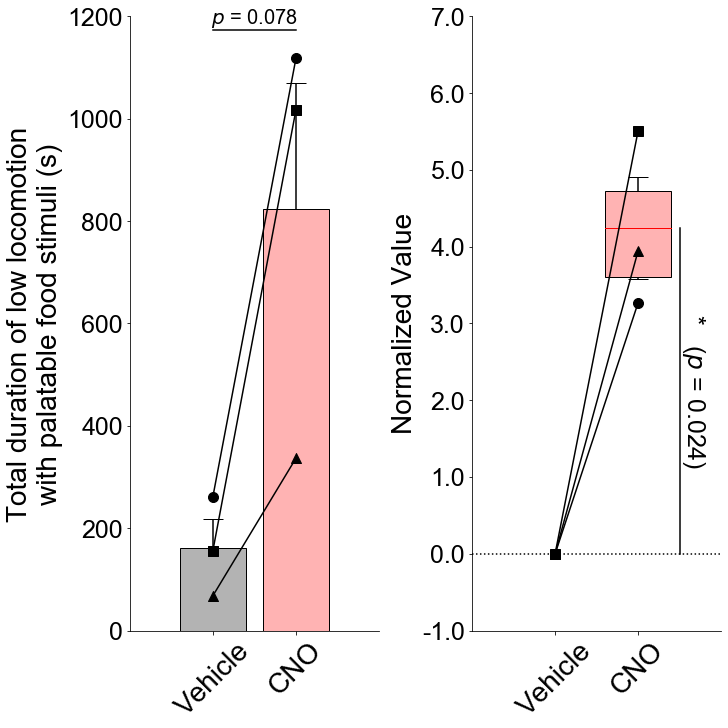

In [10]:
path = 'Figures/Fig S4A.png'
draw_picture(data, '', 'Total duration of low locomotion\nwith palatable food stimuli (s)', path)

## 4. Food Motivation on Operant Experiment Task

The following codes can be used to obtain the results related to operant experiment task.

In [11]:
files = ['Examples/CANTAB_Vehicle.csv', 'Examples/CANTAB_CNO.csv']
colors = [(0.7, 0.7, 0.7, 1.0), (1.0, 0.7, 0.7, 1.0)]
labels = ['Vehicle', 'CNO']

### 4.1. Cumulative Success Trials

We first observed the cumulative success trials over time and total number of success trials. The success trial is defined as the trial at which the subject succeed to obtain the food. One can use the samples in `Examples/CANTAB_Vehicle.csv` and `Examples/CANTAB_CNO.csv` to reproduce the same result as below.

### 4.2. Cumulative Anticipatory Behaviors

Next, we observed the cumulative anticipatory behaviors over time and total number of anticipatory behaviors. The anticipatory behavior is defined as the subject's behavior of opening the magazine door. However, the recorded number of 'Magazine Door Open' in `Examples/CANTAB_Vehicle.csv` and `Examples/CANTAB_CNO.csv` contains noise (as the door can move freely), we manually selected noises as in `Examples/CANTAB_noise_Vehicle.csv` and `Examples/CANTAB_noise_CNO.csv`.

### 4.3. Latency

Finally, we plotted the latency between (1) 'Object On' and 'Touch', and (2) 'Touch' and 'Door Open', respectively, over the trials.

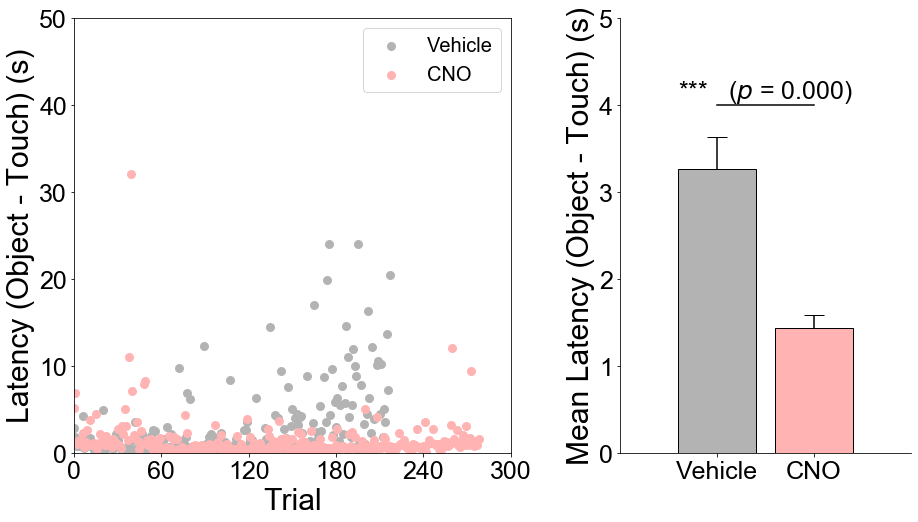

In [13]:
labelprop = arial_fontprop(30, 'bold')
tickprop = arial_fontprop(25, 'bold')
legendprop = arial_fontprop(20, 'medium')
titleprop = arial_fontprop(30, 'bold')
textprop = arial_fontprop(20, 'medium')
textprop_2 = arial_fontprop(25, 'medium')


fig, axs = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [3, 2], 'wspace': 0.3})

means = []
latencies = []

ax = axs[0]

for i, (f, color) in enumerate(zip(files, colors)):
    df = pd.read_csv(f, index_col=0, header=[0, 1])

    df = df[df.columns[:-2]]

    cols = [(a, 'time') for a, _ in np.array(df.columns).reshape(5, 2)[:, 0]]
    cols1 = np.array(df.columns).reshape(5, 2)
    cols1[:, 1] = cols
    df.columns = pd.MultiIndex.from_tuples(cols1.reshape(-1))

    data = df[['Touch', 'Object On']].dropna().values[:, [1, 3]] / 1000

    latency = data[:, 0]-data[:, 1]

    ax.scatter(np.arange(len(latency)), latency, color=color, linewidth=3, label=labels[i])

    latencies.append(latency)
    means.append(latency.mean())

ax.set_xticks(np.linspace(0, 300, 6, endpoint=True, dtype=int))
ax.set_xticklabels(ax.get_xticks(), fontproperties=tickprop)
ax.set_xlim([0, 300])
ax.set_yticks(np.linspace(0, 50, 6, endpoint=True, dtype=int))
ax.set_yticklabels(ax.get_yticks(), fontproperties=tickprop)
ax.set_ylim([0, 50])

ax.set_xlabel('Trial', fontproperties=labelprop)
ax.set_ylabel('Latency (Object - Touch) (s)', fontproperties=labelprop)

ax.legend(prop=legendprop)

ax = axs[1]

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.bar([0, 1], means, color=colors, zorder=0, edgecolor='black', width=0.8)

p = scipy.stats.ttest_ind(*latencies).pvalue
txt = get_text(p)

yerr0 = np.std(latencies[0], ddof=1)/np.sqrt(len(latencies[0]))
yerr1 = np.std(latencies[1], ddof=1)/np.sqrt(len(latencies[1]))
yerr = [yerr0, yerr1]

ax.errorbar(0, means[0], yerr = yerr[0], color='black', capsize=10, zorder=-1)
ax.errorbar(1, means[1], yerr = yerr[1], color='black', capsize=10, zorder=-1)

ax.plot([0, 1], [4, 4], color='black')
ax.text(0.5, 4, txt, fontproperties=textprop_2, ha='center', va='bottom')

ax.set_xlim([-1, 2])
ax.set_xticks([0.0, 1.0])
ax.set_xticklabels(['Vehicle', 'CNO'], fontproperties=tickprop)

ax.set_yticks(np.linspace(0, 5, 6, endpoint=True, dtype=int))
ax.set_yticklabels(ax.get_yticks(), fontproperties=tickprop)
ax.set_ylim([0, 5])
ax.set_ylabel('Mean Latency (Object - Touch) (s)', fontproperties=labelprop)

fig.savefig('Figures/Fig 7B.png')


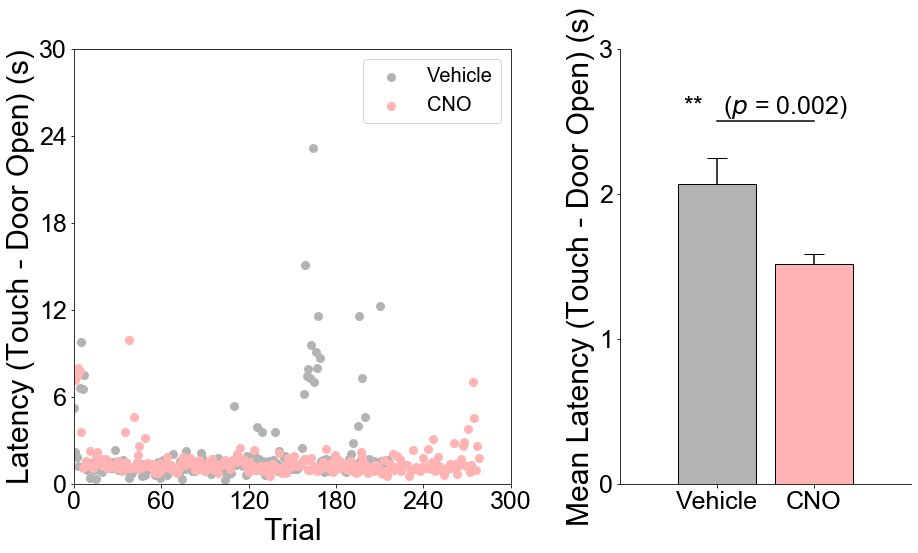

In [15]:
labelprop = arial_fontprop(30, 'bold')
tickprop = arial_fontprop(25, 'bold')
legendprop = arial_fontprop(20, 'medium')
titleprop = arial_fontprop(30, 'bold')
textprop = arial_fontprop(20, 'medium')
textprop_2 = arial_fontprop(25, 'medium')

def foo(arr1, arr2):
    j = 0
    result = []
    for val1 in arr1:
        while j in range(len(arr2)):
            if arr2[j] > val1:
                result.append(arr2[j])
                j += 1
                break
            j += 1
            continue
    return result

fig, axs = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [3, 2], 'wspace': 0.3})

means = []
latencies = []

ax = axs[0]

for i, (f, color) in enumerate(zip(files, colors)):
    df = pd.read_csv(f, index_col=0, header=[0, 1])

    df = df[df.columns[:-2]]

    cols = [(a, 'time') for a, _ in np.array(df.columns).reshape(5, 2)[:, 0]]
    cols1 = np.array(df.columns).reshape(5, 2)
    cols1[:, 1] = cols
    df.columns = pd.MultiIndex.from_tuples(cols1.reshape(-1))

    arr1 = df[('Touch', 'time')].dropna() / 1000
    arr2 = df[('Magazine Door Open', 'time')].dropna() / 1000

    result = np.array(foo(arr1, arr2))

    latency = result - arr1[:len(result)]

    latencies.append(latency)

    ax.scatter(np.arange(len(latency)), latency, color=color, linewidth=3, label=labels[i])

    means.append(latency.mean())

ax.set_xticks(np.linspace(0, 300, 6, endpoint=True, dtype=int))
ax.set_xticklabels(ax.get_xticks(), fontproperties=tickprop)
ax.set_xlim([0, 300])
ax.set_yticks(np.linspace(0, 30, 6, endpoint=True, dtype=int))
ax.set_yticklabels(ax.get_yticks(), fontproperties=tickprop)
ax.set_ylim([0, 30])

ax.set_xlabel('Trial', fontproperties=labelprop)
ax.set_ylabel('Latency (Touch - Door Open) (s)', fontproperties=labelprop)

ax.legend(prop=legendprop)

ax = axs[1]

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.bar([0, 1], means, color=colors, zorder=0, edgecolor='black', width=0.8)

p = scipy.stats.ttest_ind(*latencies).pvalue
txt = get_text(p)

yerr0 = np.std(latencies[0], ddof=1)/np.sqrt(len(latencies[0]))
yerr1 = np.std(latencies[1], ddof=1)/np.sqrt(len(latencies[1]))
yerr = [yerr0, yerr1]

ax.errorbar(0, means[0], yerr = yerr[0], color='black', capsize=10, zorder=-1)
ax.errorbar(1, means[1], yerr = yerr[1], color='black', capsize=10, zorder=-1)

ax.plot([0, 1], [2.5, 2.5], color='black')
ax.text(0.5, 2.5, txt, fontproperties=textprop_2, ha='center', va='bottom')


ax.set_xlim([-1, 2])
ax.set_xticks([0.0, 1.0])
ax.set_xticklabels(['Vehicle', 'CNO'], fontproperties=tickprop)

ax.set_yticks(np.linspace(0, 3, 4, endpoint=True, dtype=int))
ax.set_yticklabels(ax.get_yticks(), fontproperties=tickprop)
ax.set_ylim([0, 3])
ax.set_ylabel('Mean Latency (Touch - Door Open) (s)', fontproperties=labelprop)

fig.savefig('Figures/Fig 7C.png')